# Plot SWOT fields and spectra 

In this script we read in the SWOT data from a Pass between specified lats and plot the fields and spectra

In [1]:
import JWS_SWOT_toolbox as swot
import numpy as np
%load_ext autoreload
%autoreload 2

### Import SWOT data and files first for a specified pass and between some lats

In [4]:
# Read in the SWOT data for this pass
pass_num = 9
lat_max = 35 #38 #38
lat_min = 28 #28 #28

data_folder = '/expanse/lustre/projects/cit197/jskinner1/SWOT/CALVAL/' # where our data is stored

# finds overlapping cycles between the karin and nadir datasets
_, _, shared_cycles, karin_files, nadir_files = swot.return_swot_files(data_folder, pass_num) 

sample_index = 2 # this is just some index we use to pull a preliminary file and get our track indices 
indx, track_length = swot.get_karin_track_indices(karin_files[sample_index][0], lat_min, lat_max)
indxs, track_length_nadir = swot.get_nadir_track_indices(nadir_files[sample_index][0], lat_min, lat_max)
dims_SWOT = [len(shared_cycles), track_length, track_length_nadir]

karin, nadir = swot.init_swot_arrays(dims_SWOT, lat_min, lat_max, pass_num)

# read and process the karin data
swot.load_karin_data(karin_files, lat_min, lat_max, karin, verbose=False)
swot.process_karin_data(karin)

# read and process the nadir data
swot.load_nadir_data(nadir_files, lat_min, lat_max, nadir)
swot.process_nadir_data(nadir)

# generate the coordinates
karin.coordinates()
nadir.coordinates()

# Compute spectra
karin.compute_spectra()
nadir.compute_spectra()

KaRIn Cycle 496 dropped: >20% bad-quality points
KaRIn Cycle 497 dropped: >20% bad-quality points


/home/jskinner1/SWOT_tools/src/JWS_SWOT_toolbox/import_and_process.py:230: RuntimeWarning: Degrees of freedom <= 0 for slice.
  varts = np.nanvar(ssha_array, axis=(1, 2))


Overall SSH variance (overall_var): 0.017327167681867872
File indices with outlier variance: []
----------------------------------
Total Number of Good KaRIn strips : 186
Number of Quality Masked KaRIn strips : 127
Number of High Variance strips removed : 0

Number of good nadir cycles: 95
Number of bad nadir cycles: 0
X grid range (km): 0.00 to 256.41 (span: 256.41 km)
Y grid range (km): 0.00 to 797.81 (span: 797.81 km)
Track Length: 797.81 km
Swath Width: 128.20 km
Karin spacing: dx = 2.00 km, dy = 2.00 km
Nadir spacing: dy = 6.85 km
Computing KaRIn spectra...
Computing Nadir spectra...


### Plot the fields and spectra 

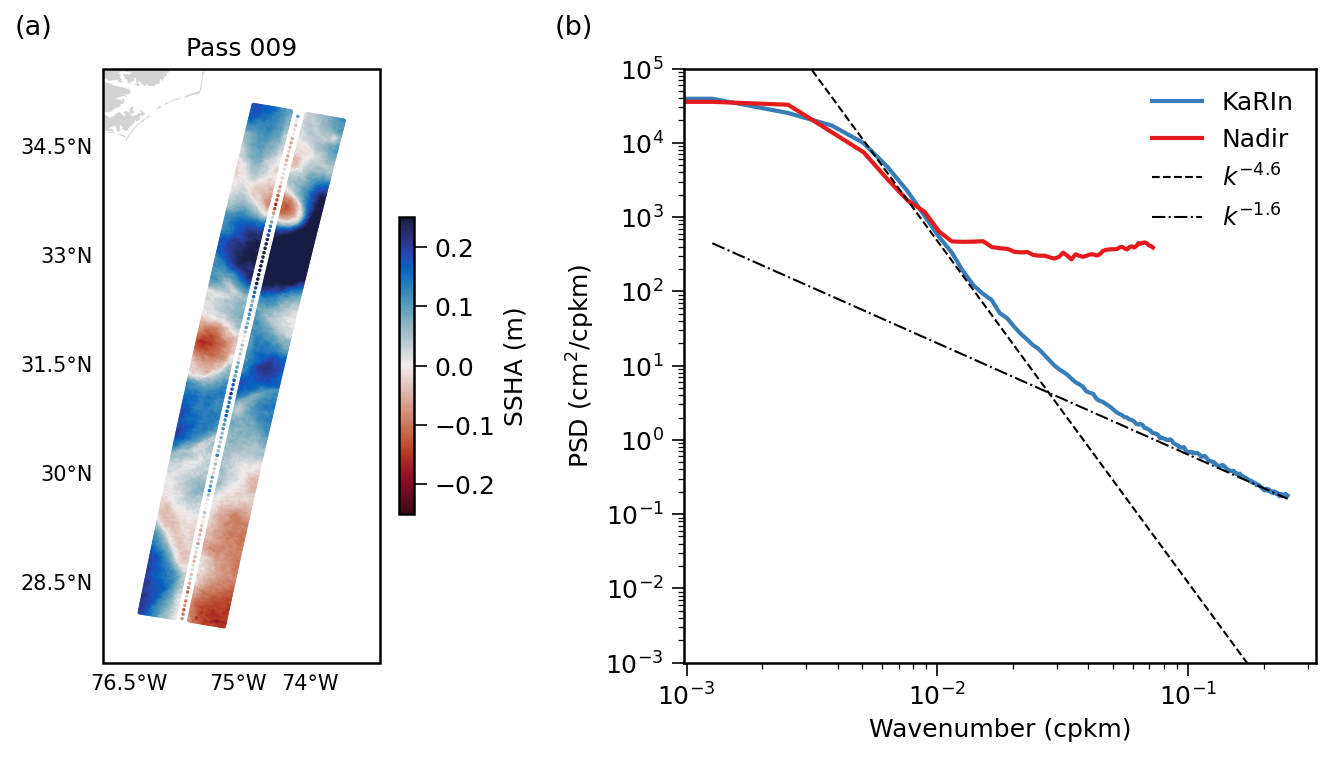

In [15]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import cartopy
import cartopy.crs as ccrs
import numpy as np
import cmocean

swot.set_plot_style()

index = 10
vmin, vmax = -0.25, 0.25
ylims = (1e-3, 1e5)
cmap = 'cmo.balance_r' #cmocean.cm.balance

fig = plt.figure(figsize=(10, 5), dpi=150)
gs = GridSpec(1, 2, width_ratios=[1, 1.0], figure=fig)

# ───── SWOT Map ─────

# Define padding in degrees
pad = 0.5

lon_min = np.nanmin(karin.lon[index]) - pad
lon_max = np.nanmax(karin.lon[index]) + pad
lat_min = np.nanmin(karin.lat[index]) - pad
lat_max = np.nanmax(karin.lat[index]) + pad

ax0 = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree())
ax0.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

sc0 = ax0.scatter(
    karin.lon[index], karin.lat[index],
    c=karin.ssha[index], s=1, vmin=vmin, vmax=vmax, cmap=cmap,
    transform=ccrs.PlateCarree(), marker='o', 
    rasterized=True
)
ax0.scatter(
    nadir.lon[index], nadir.lat[index],
    c=nadir.ssh[index], s=0.5, vmin=vmin, vmax=vmax,
    cmap=cmap, transform=ccrs.PlateCarree(), marker='o', 
    rasterized=True
)
#ax0.coastlines()
ax0.add_feature(cartopy.feature.LAND, facecolor='lightgrey', edgecolor='none', zorder=0)
ax0.set_title(f'Pass {pass_num:03d}')
gl0 = ax0.gridlines(draw_labels=True, linewidth=0.5, alpha=0.0)
gl0.top_labels = gl0.right_labels = False
cbar0 = fig.colorbar(sc0, ax=ax0, orientation='vertical', shrink=0.5, pad=0.03)
cbar0.set_label("SSHA (m)")

# ───── Power Spectrum ─────
ax1 = fig.add_subplot(gs[0, 1])

ax1.loglog(karin.wavenumbers_cpkm,  karin.spec_ssha, label='KaRIn', linewidth=2.)
ax1.loglog(nadir.wavenumbers_cpkm,  nadir.spec_ssha, label='Nadir', linewidth=2.)
#ax1.loglog(karin.wavenumbers * 1e3, karin.spec_ssh, label='SWOT KaRIn SSH', linewidth=2.0)
#ax1.loglog(karin.wavenumbers * 1e3, karin.spec_tmean, label='SWOT Time-mean', linewidth=2.0)
#ax1.loglog(karin.wavenumbers * 1e3, karin.spec_tide, label='SWOT HRET', linewidth=2.0)

# Reference slope lines (k^-5 and k^-2)
k_ref = karin.wavenumbers_cpkm  # range of wavenumbers (cpkm)
C1 = 3e-7  # vertical placement for k^-5
C2 = 2e-2  # vertical placement for k^-2
ax1.loglog(k_ref, C1 * k_ref**-4.6, 'k--', linewidth=1, label=r'$k^{-4.6}$')
ax1.loglog(k_ref, C2 * k_ref**-1.5, 'k', linestyle='-.', linewidth=1, label=r'$k^{-1.6}$')


ax1.set_xlabel("Wavenumber (cpkm)")
ax1.set_ylabel("PSD (cm$^2$/cpkm)")
ax1.set_ylim(ylims)
ax1.legend()

# (a) for left panel
fig.text(0.13, 1, "(a)", fontsize=13, 
         va="top", ha="center")

# (b) for right panel
fig.text(0.49, 1, "(b)", fontsize=13, 
         va="top", ha="center")


plt.tight_layout()
fig.savefig("swot_map_spectrum.pdf", bbox_inches='tight')
plt.show()

## Fit Spectrum Models

### Averaged across the track 


---- KaRIn spectrum parameters ----
Amp. balanced   :   2.6973e+04 ± 2.67e+02
lambda balanced :   2.2638e+02 ± 1.58e+00
slope balanced  :   4.6112e+00 ± 5.06e-02
Amp. noise      :   2.8115e+01 ± 2.94e+01
lambda noise    :   1.0001e+02 ± 7.34e+01
slope noise     :   1.5144e+00 ± 2.78e-02

---- Nadir spectrum parameters ----
Fitted Nadir noise floor N = 324.34807509094344 ± 1.45e+01


(<Figure size 960x480 with 2 Axes>,
 array([<Axes: title={'center': 'KaRIn'}, xlabel='wavenumber (cpkm)', ylabel='PSD (cm$^2$ / cpkm)'>,
        <Axes: title={'center': 'Nadir'}, xlabel='wavenumber (cpkm)', ylabel='PSD (cm$^2$ / cpkm)'>],
       dtype=object))

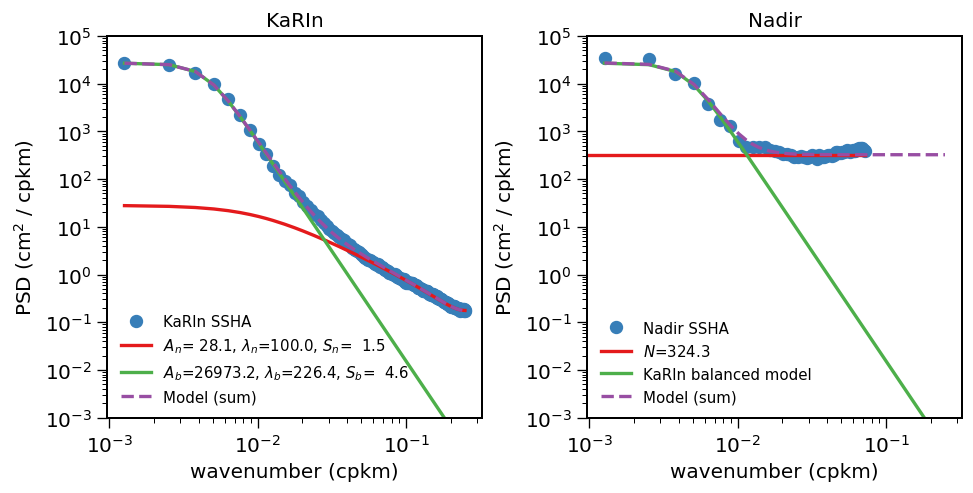

In [16]:
# KaRIn model fit
poptcwg_karin, pcovcwg_karin = swot.fit_spectrum(karin, karin.spec_alongtrack_av, swot.karin_model)

# Nadir model fit
poptcwg_nadir, covcwg_nadir = swot.fit_nadir_spectrum(nadir, nadir.spec_alongtrack_av, poptcwg_karin)

# Plot the fits
swot.plot_spectral_fits(karin, nadir, poptcwg_karin, poptcwg_nadir, 'balanced_fits.pdf')

### Make the Combined Plot 

2023-04-11T03:23:46.225832000
487
KaRIn crossover: k = 0.0278 cpkm  (λ ≈ 35.9 km)
Nadir crossover: k = 0.0114 cpkm  (λ ≈ 87.5 km)


/scratch/jskinner1/job_43205164/ipykernel_621667/575965848.py:165: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


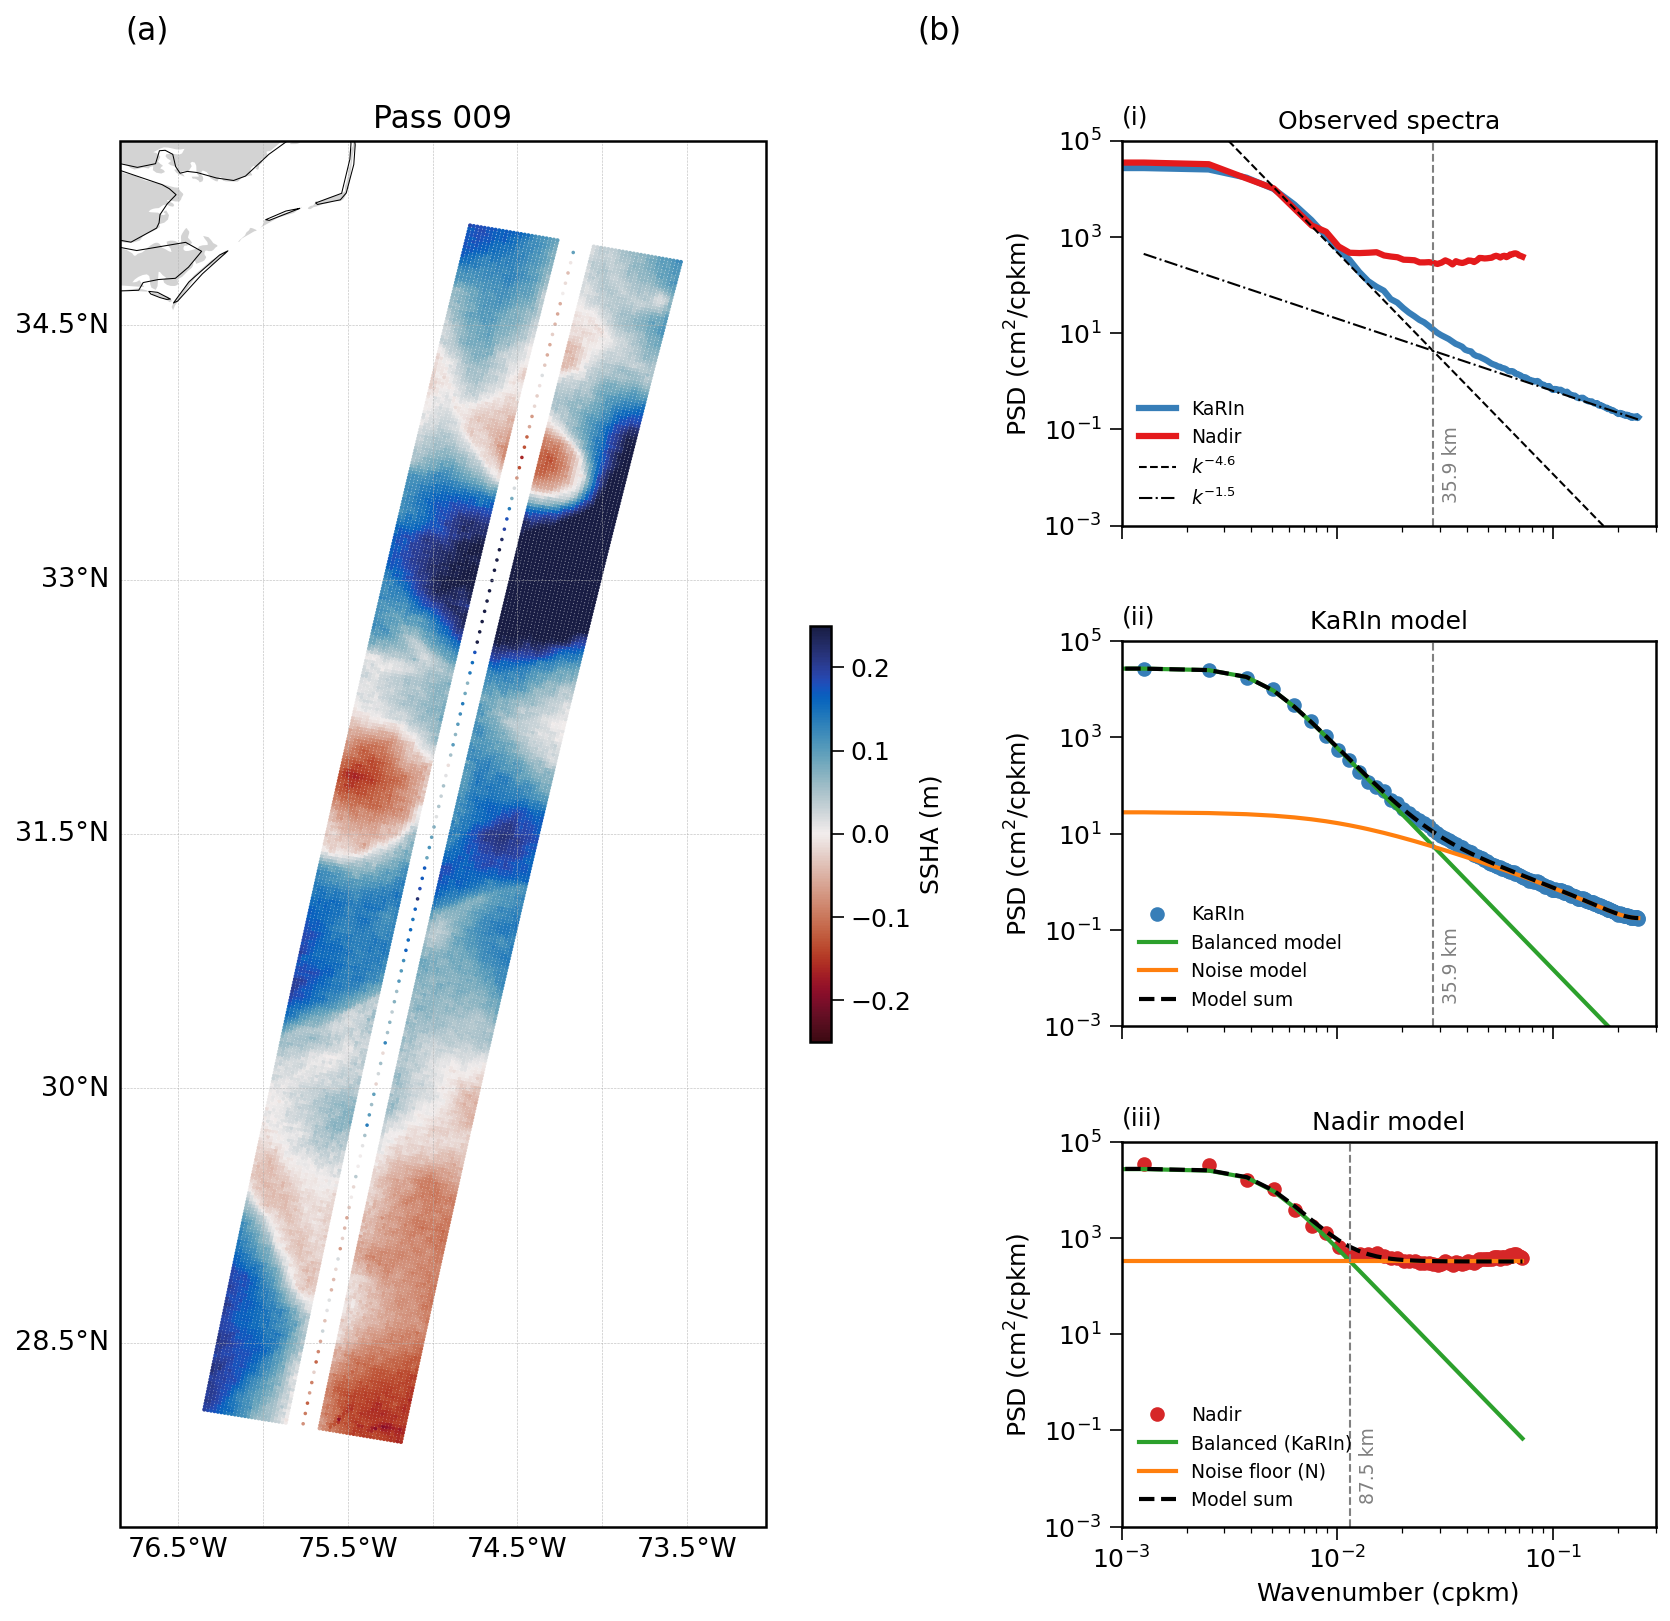

In [92]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# optional style (if available)
try:
    swot.set_plot_style()
except Exception:
    pass

# index for the pass to plot
index = 10
print(karin.time_dt[index])

print(shared_cycles[index])

# one-sided wavenumbers & spectra (take positive half)
tlen_k = int(karin.track_length // 2)
tlen_n = int(nadir.track_length // 2)

k_karin = np.asarray(karin.wavenumbers_cpkm[tlen_k:])
karin_spec = np.asarray(karin.spec_alongtrack_av[tlen_k:])

k_nadir = np.asarray(nadir.wavenumbers_cpkm[tlen_n:])
nadir_spec = np.asarray(nadir.spec_alongtrack_av[tlen_n:])

# model components
sp_balanced_karin = swot.balanced_model(k_karin, *poptcwg_karin[0:3])
sp_unbalanced_karin = swot.unbalanced_model_aliased(k_karin, *poptcwg_karin[3:6])
model_sum_karin = sp_balanced_karin + sp_unbalanced_karin

sp_noise_nadir = swot.nadir_noise_model(k_nadir, poptcwg_nadir[0])
sp_balanced_nadir = swot.balanced_model(k_nadir, *poptcwg_karin[0:3])
model_sum_nadir = sp_balanced_nadir + sp_noise_nadir

# --- shared x-axis limits ---
kmin = 1e-3
kmax = 3e-1

# figure layout: left large map, right column with 3 stacked spectra (sharing x)
fig = plt.figure(figsize=(12, 12), dpi=150)
gs = GridSpec(nrows=3, ncols=2, figure=fig,
              width_ratios=[2.0, 1.2], height_ratios=[1, 1, 1],
              hspace=0.3, wspace=0.25)

fig.subplots_adjust(left=0.01)  # push leftmost column all the way left

# ----- Large map (left column spanning all rows) -----
ax_map = fig.add_subplot(gs[:, 0], projection=ccrs.PlateCarree())
pad = 0.5
lon_min = np.nanmin(karin.lon[index]) - pad
lon_max = np.nanmax(karin.lon[index]) + pad
lat_min = np.nanmin(karin.lat[index]) - pad
lat_max = np.nanmax(karin.lat[index]) + pad
ax_map.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

sc = ax_map.scatter(karin.lon[index], karin.lat[index],
                    c=karin.ssha[index], s=1.0, cmap='cmo.balance_r',
                    vmin=-0.25, vmax=0.25, transform=ccrs.PlateCarree(),
                    marker='o', rasterized=True, zorder=2)
ax_map.scatter(nadir.lon[index], nadir.lat[index],
               c=nadir.ssh[index], s=0.5, cmap='cmo.balance_r',
               vmin=-0.25, vmax=0.25, transform=ccrs.PlateCarree(),
               marker='o', rasterized=True, zorder=1)
ax_map.add_feature(cfeature.LAND, facecolor='lightgrey', zorder=0)
ax_map.coastlines(resolution='50m', linewidth=0.5, zorder=3)
gl = ax_map.gridlines(draw_labels=True, linewidth=0.3, alpha=0.8)
gl.top_labels = False
gl.right_labels = False
ax_map.set_title(f'Pass {pass_num:03d}', fontsize=15)
cbar = fig.colorbar(sc, ax=ax_map, orientation='vertical', shrink=0.3, pad=0.05)
cbar.set_label('SSHA (m)')

# increase font size for latitude/longitude labels
gl.xlabel_style = {'size': 13}  # longitude labels
gl.ylabel_style = {'size': 13}  # latitude labels

# --- Y-limits for PSD ---
ylims = (1e-3, 1e5)

# create three stacked spectra sharing x-axis
ax_top  = fig.add_subplot(gs[0, 1])
ax_mid  = fig.add_subplot(gs[1, 1], sharex=ax_top)
ax_bot  = fig.add_subplot(gs[2, 1], sharex=ax_top)

# ----- Top-right: observed spectra -----
ax_top.loglog(k_karin, karin_spec, label='KaRIn', linewidth=3.0)
ax_top.loglog(k_nadir, nadir_spec, label='Nadir', linewidth=3.0)
ax_top.loglog(k_ref, C1 * k_ref**-4.6, 'k--', linewidth=1, label=r'$k^{-4.6}$')
ax_top.loglog(k_ref, C2 * k_ref**-1.5, 'k', linestyle='-.', linewidth=1, label=r'$k^{-1.5}$')
ax_top.set_ylabel('PSD (cm$^2$/cpkm)')
ax_top.set_ylim(ylims)
ax_top.set_xlim(kmin, kmax)
ax_top.set_title('Observed spectra')
ax_top.legend(fontsize=9, loc='lower left')
plt.setp(ax_top.get_xticklabels(), visible=False)

# ----- Middle-right: KaRIn data + fits -----
ax_mid.loglog(k_karin, karin_spec, 'o',markersize = 6, label='KaRIn')
ax_mid.loglog(k_karin, sp_balanced_karin, '-', color='tab:green', label='Balanced model')
ax_mid.loglog(k_karin, sp_unbalanced_karin, '-', color='tab:orange', label='Noise model')
ax_mid.loglog(k_karin, model_sum_karin, '--k', label='Model sum')
ax_mid.set_ylabel('PSD (cm$^2$/cpkm)')
ax_mid.set_ylim(ylims)
ax_mid.legend(fontsize=9, loc='lower left')
ax_mid.set_title('KaRIn model')
plt.setp(ax_mid.get_xticklabels(), visible=False)

# ----- Bottom-right: Nadir data + fits -----
ax_bot.loglog(k_nadir, nadir_spec, 'o',markersize = 6, color='tab:red', label='Nadir')
ax_bot.loglog(k_nadir, sp_balanced_nadir, '-',  color='tab:green', label='Balanced (KaRIn)')
ax_bot.loglog(k_nadir, sp_noise_nadir, '-', color='tab:orange', label='Noise floor (N)')
ax_bot.loglog(k_nadir, model_sum_nadir, '--k', label='Model sum')
ax_bot.set_xlabel('Wavenumber (cpkm)')
ax_bot.set_ylabel('PSD (cm$^2$/cpkm)')
ax_bot.set_ylim(ylims)
ax_bot.legend(fontsize=9, loc='lower left')
ax_bot.set_title('Nadir model')

# small panel labels
fig.text(0.05, 0.95, "(a)", fontsize=15, va="top")
fig.text(0.49, 0.95, "(b)", fontsize=15, va="top")

ax_top.text(0.0, 1.03, '(i)', transform=ax_top.transAxes,
            fontsize=12, va='bottom', ha='left')
ax_mid.text(0.0, 1.03, '(ii)', transform=ax_mid.transAxes,
            fontsize=12, va='bottom', ha='left')
ax_bot.text(0.0, 1.03, '(iii)', transform=ax_bot.transAxes,
            fontsize=12, va='bottom', ha='left')

# add a grey line for the transition scale 

# ---- Find where balanced and noise models are equal ----
# KaRIn crossover (balanced vs unbalanced/aliased)
ratio_karin = sp_balanced_karin / sp_unbalanced_karin
cross_idx_karin = np.argmin(np.abs(np.log10(ratio_karin)))
k_cross_karin = k_karin[cross_idx_karin]
lambda_cross_karin = 1 / k_cross_karin
print(f"KaRIn crossover: k = {k_cross_karin:.4f} cpkm  (λ ≈ {lambda_cross_karin:.1f} km)")

# Nadir crossover (balanced vs noise floor)
ratio_nadir = sp_balanced_nadir / sp_noise_nadir
cross_idx_nadir = np.argmin(np.abs(np.log10(ratio_nadir)))
k_cross_nadir = k_nadir[cross_idx_nadir]
lambda_cross_nadir = 1 / k_cross_nadir
print(f"Nadir crossover: k = {k_cross_nadir:.4f} cpkm  (λ ≈ {lambda_cross_nadir:.1f} km)")

# ---- Add vertical grey lines ----

for ax in [ax_top, ax_mid]:
    # KaRIn crossover
    ax.axvline(k_cross_karin, color='grey', linestyle='--', linewidth=1.0, alpha=1.0)
    ax.text(k_cross_karin * 1.1, 3e-3,
            f'{lambda_cross_karin:.1f} km',
            rotation=90, color='grey', fontsize=9, va='bottom', ha='left')
for ax in [ax_bot]:
    # Nadir crossover
    ax.axvline(k_cross_nadir, color='grey', linestyle='--', linewidth=1.0, alpha=1.0)
    ax.text(k_cross_nadir * 1.1, 3e-3,
            f'{lambda_cross_nadir:.1f} km',
            rotation=90, color='grey', fontsize=9, va='bottom', ha='left')

plt.tight_layout()
fig.savefig("fig1.pdf", bbox_inches='tight')
plt.show()


### Now at each line across the track 

In [13]:
import matplotlib.pyplot as plt
import os
import numpy as np

spec = karin.spec_alongtrack_time_av  # (freq_line, pixel)
k = karin.wavenumbers_cpkm  # frequency coordinate [cycles/km]

npixels = spec.shape[1]
poptall = np.zeros((npixels, 6))
covall  = np.zeros((npixels, 6))

# === Fit spectrum at each pixel ===
for i in range(npixels): 
    if ~np.isnan(spec[:, i]).any(): 
        pop_karin, pcov_karin = swot.fit_spectrum(karin, spec[:, i], swot.karin_model, verbose=False)
        poptall[i] = pop_karin
        covall[i] = np.diag(pcov_karin)
    else: 
        print(f'Pixel {i} is NaN')

# === Save fitted parameters ===
np.save('./outputs/fitparams_pass%d.npy' % pass_num, poptall)
np.save('./outputs/fitcov_pass%d.npy' % pass_num, covall)

# === Plot all spectra with first and last highlighted ===
plt.figure(figsize=(8, 5))
for i in range(npixels):
    y = spec[:, i]
    valid = (y > 0) & (k > 0)
    color = 'tab:red' if i == 0 else 'tab:green' if i == npixels - 1 else 'gray'
    lw = 2.0 if i in [0, npixels - 1] else 0.8
    alpha = 1.0 if i in [0, npixels - 1] else 0.4
    plt.plot(k[valid], y[valid]*1e-3, color=color, linewidth=lw, alpha=alpha)

plt.loglog(karin.wavenumbers_cpkm[1:], karin.spec_alongtrack_av[1:], 'k-', label='AlongTrack Av.', linewidth=1.5)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Wavenumber [cpkm]')
plt.ylabel('Power [m²/cpkm]')
plt.title('Time-averaged 1D Spectra Across Track')
plt.grid(True, which='both', ls='--', alpha=0.3)
plt.tight_layout()
plt.show()

RuntimeError: Optimal parameters not found: The maximum number of function evaluations is exceeded.

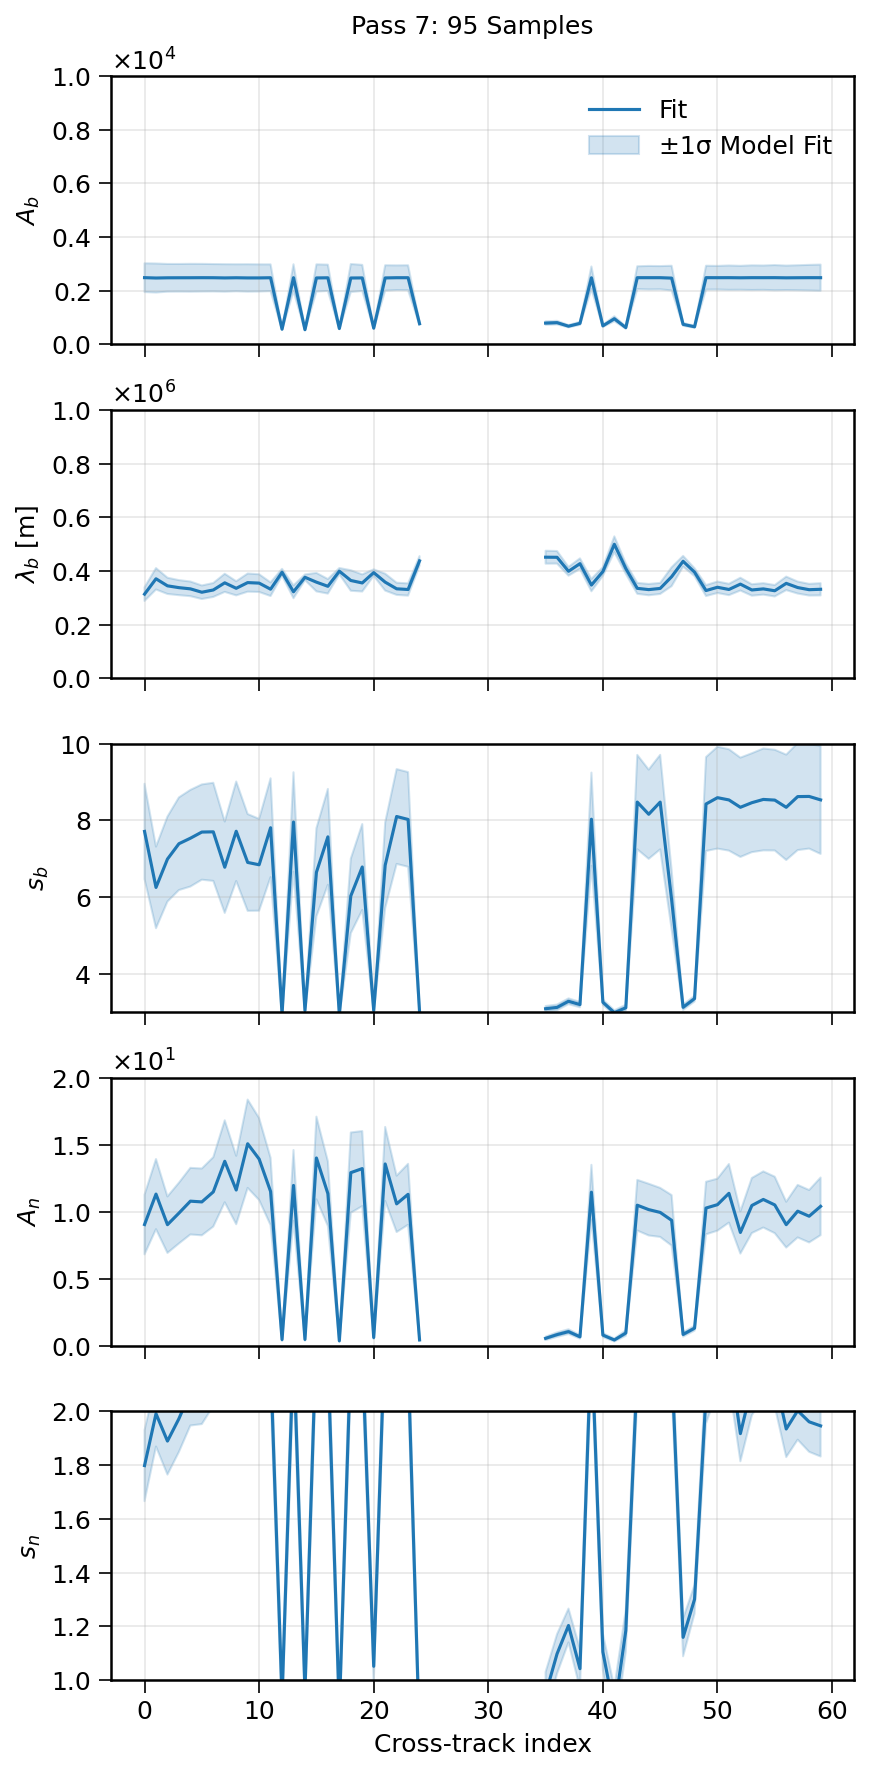

In [23]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

swot.set_plot_style()

# Skip parameter index 4 (lambda_n), so plot only these
plot_indices = [0, 1, 2, 3, 5]

labels = [r'$A_b$', r'$\lambda_b$ [m]', r'$s_b$', r'$A_n$', r'$s_n$']

# Define manual y-limits for each parameter in the same order as plot_indices
ylims = [
    (0, 1e4),       # A_b
    (0, 1e6),     # lambda_b [m]
    (3, 10),         # s_b
    (0, 20),        # A_n
    (1.0, 2)          # s_n
]

fig, axes = plt.subplots(len(plot_indices), figsize=(6, 12), dpi=150, sharex=True)

n_pixels = poptall.shape[0]
gap_width = 10
mid = n_pixels // 2
gap_start, gap_end = mid - gap_width // 2, mid + gap_width // 2

mask = np.ones(n_pixels, dtype=bool)
mask[gap_start:gap_end] = False

# Plot each parameter
for ax, i, label, ylim in zip(axes, plot_indices, labels, ylims):
    y = np.copy(poptall[:, i])
    yerr = np.sqrt(covall[:, i])

    y[~mask] = np.nan
    yerr[~mask] = np.nan

    ax.plot(y, color='tab:blue', linewidth=1.5, label='Fit')
    ax.fill_between(
        np.arange(n_pixels),
        y - yerr,
        y + yerr,
        color='tab:blue', alpha=0.2,
        label='±1σ Model Fit' if i == 0 else None
    )

    ax.set_ylabel(label)
    ax.grid(True, linestyle='-', alpha=0.3)
    ax.set_ylim(*ylim)

    if np.nanmax(np.abs(y)) > 10:
        ax.yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
        ax.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))

axes[-1].set_xlabel('Cross-track index')
axes[0].legend(loc='best')

plt.suptitle(f'Pass {pass_num}: {len(shared_cycles)} Samples', x=0.55, ha='center')
plt.tight_layout()
plt.savefig('cross_track_model.pdf')
plt.show()

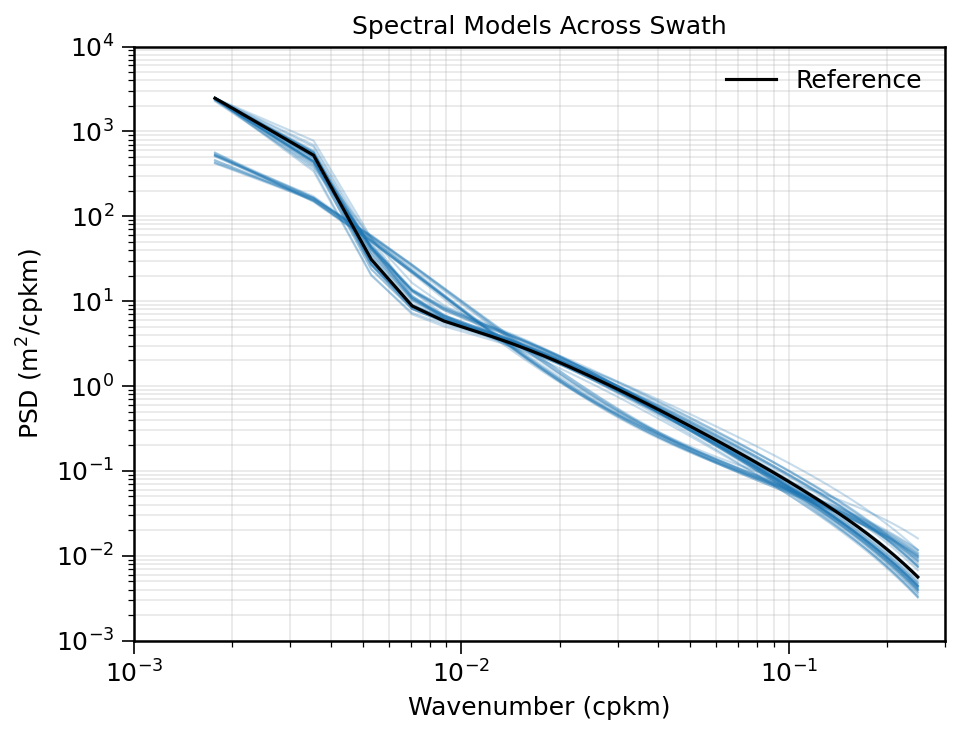

In [24]:
import matplotlib.pyplot as plt
import numpy as np

swot.set_plot_style()

# Define wavenumber domain
k = karin.wavenumbers[int(karin.track_length // 2):]  # [1/m]
k_km = k[1:] * 1e3  # skip k=0, convert to cpkm
n_pixels = poptall.shape[0]

# Define center gap mask
gap_width = 10
mid = n_pixels // 2
gap_start, gap_end = mid - gap_width // 2, mid + gap_width // 2
mask = np.ones(n_pixels, dtype=bool)
mask[gap_start:gap_end] = False

# Create figure
fig, ax = plt.subplots(figsize=(6.5, 5), dpi=150)

# Plot individual model fits
for i in range(n_pixels):
    if not mask[i]:
        continue
    popt = poptall[i]
    if not np.all(np.isfinite(popt)):
        continue

    sb = swot.balanced_model(k[1:], *popt[0:3])
    sn = swot.unbalanced_model(k, *popt[3:7])[1:]  # match domain
    stotal = sb + sn

    ax.loglog(k_km, stotal, color='tab:blue', alpha=0.25, linewidth=1)

# Overlay reference model fit (from poptcwg_karin)
sb_ref = swot.balanced_model(k[1:], *poptcwg_karin[0:3])
sn_ref = swot.unbalanced_model(k, *poptcwg_karin[3:7])[1:]
stotal_ref = sb_ref + sn_ref

ax.loglog(k_km, stotal_ref, color='black', linewidth=1.5, label='Reference')

# Plot style
ax.set_xlabel('Wavenumber (cpkm)')
ax.set_ylabel('PSD (m$^2$/cpkm)')
ax.set_xlim(1e-3, 3e-1)
ax.set_ylim(1e-3, 1e4)
ax.set_title('Spectral Models Across Swath')
ax.legend(frameon=False)
ax.grid(True, which='both', linestyle='-', alpha=0.3)

plt.tight_layout()
plt.savefig('spectral_model_overlay_reference.pdf')
plt.show()


## Read in all pass parameters and plot over them

/scratch/jskinner1/job_41415725/ipykernel_1564199/3405424167.py:68: RuntimeWarning: Mean of empty slice
  param_mean = np.nanmean(param_stack, axis=0)
/home/jskinner1/miniconda3/envs/d3/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


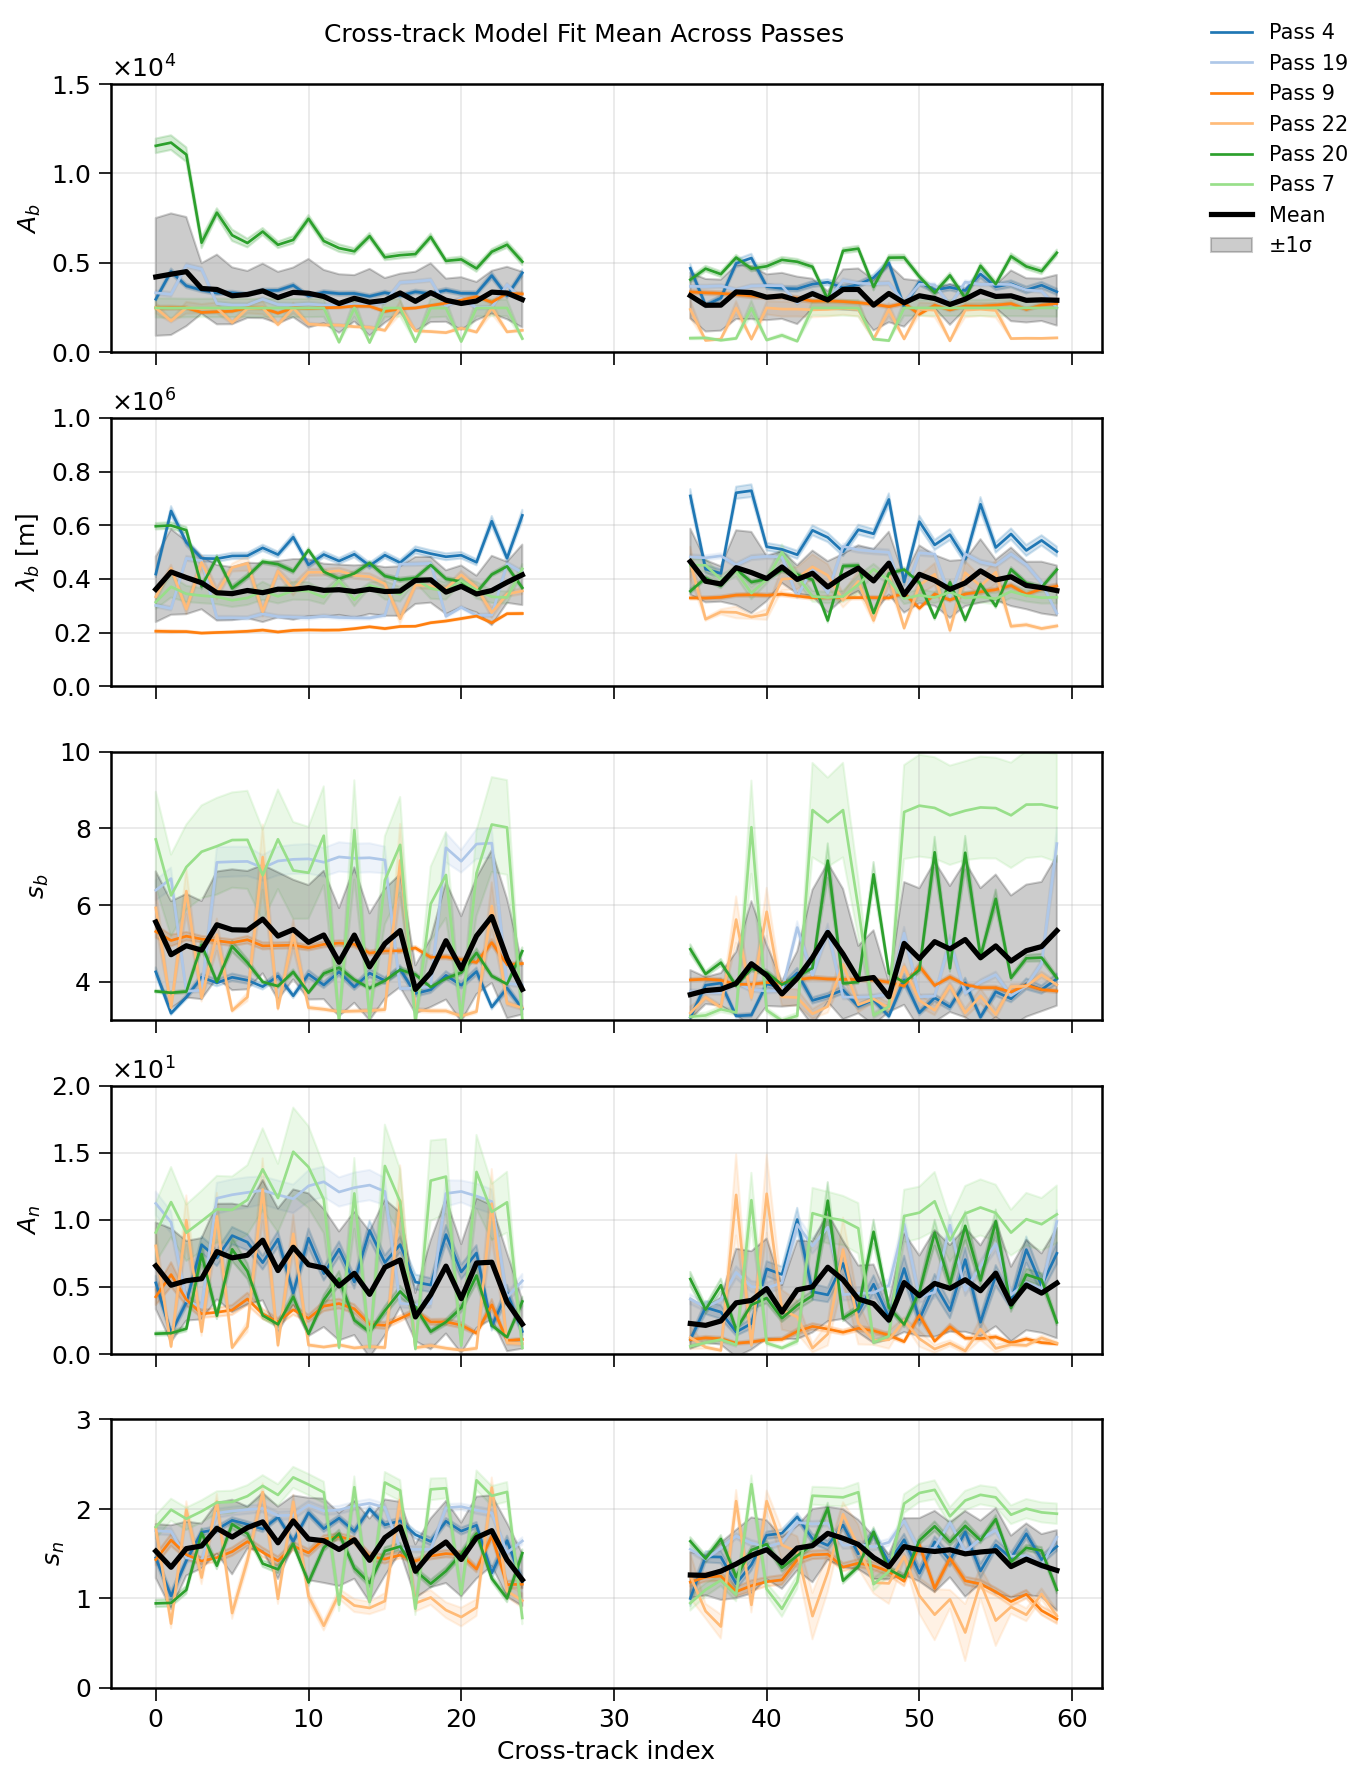

In [25]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import os

swot.set_plot_style()

# === Settings ===
passes = [4, 19, 9, 22, 20, 7]
labels = [r'$A_b$', r'$\lambda_b$ [m]', r'$s_b$', r'$A_n$', r'$s_n$']
plot_indices = [0, 1, 2, 3, 5]
ylims = [
    (0, 1.5e4),     # A_b
    (0, 1e6),     # lambda_b [m]
    (3, 10),      # s_b
    (0, 20),      # A_n
    (0, 3)        # s_n
]
colors = plt.cm.tab20.colors

# === Set up figure and storage ===
fig, axes = plt.subplots(len(plot_indices), figsize=(9, 12), dpi=150, sharex=True)

all_params = {i: [] for i in plot_indices}

for j, pass_num in enumerate(passes):
    # Load parameters and covariances
    poptall = np.load(f"./outputs/fitparams_pass{pass_num}.npy")
    covall  = np.load(f"./outputs/fitcov_pass{pass_num}.npy")

    n_pixels = poptall.shape[0]
    gap_width = 10
    mid = n_pixels // 2
    gap_start, gap_end = mid - gap_width // 2, mid + gap_width // 2
    mask = np.ones(n_pixels, dtype=bool)
    mask[gap_start:gap_end] = False

    for ax, i, label, ylim in zip(axes, plot_indices, labels, ylims):
        y = np.copy(poptall[:, i])
        yerr = np.sqrt(covall[:, i])

        y[~mask] = np.nan
        yerr[~mask] = np.nan

        color = colors[j % len(colors)]
        ax.plot(y, label=f'Pass {pass_num}', linewidth=1.3, color=color)
        ax.fill_between(
            np.arange(n_pixels),
            y - yerr,
            y + yerr,
            color=color,
            alpha=0.2
        )

        all_params[i].append(y)

        ax.set_ylabel(label)
        ax.set_ylim(*ylim)
        ax.grid(True, linestyle='-', alpha=0.3)

        if np.nanmax(np.abs(y)) > 10:
            ax.yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
            ax.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))

# === Plot mean ± std across passes ===
for ax, i in zip(axes, plot_indices):
    param_stack = np.stack(all_params[i])  # shape: (n_passes, n_pixels)
    param_mean = np.nanmean(param_stack, axis=0)
    param_std  = np.nanstd(param_stack, axis=0)

    ax.plot(param_mean, color='k', linewidth=2.5, label='Mean')
    ax.fill_between(
        np.arange(n_pixels),
        param_mean - param_std,
        param_mean + param_std,
        color='k', alpha=0.2, label='±1σ' if i == plot_indices[0] else None
    )

axes[-1].set_xlabel('Cross-track index')

# === External legend ===
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper left', bbox_to_anchor=(0.9, 0.99), fontsize=10)

plt.suptitle('Cross-track Model Fit Mean Across Passes', x=0.45, ha='center')
plt.tight_layout(rect=[0, 0, 0.85, 1])  # leave space on right for legend
plt.savefig('cross_track_model_mean_std.pdf', bbox_inches='tight')
plt.show()
